In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
data=pd.read_csv('dataset.csv')
data

,Kode Produk,19-Jan,19-Feb,19-Mar,19-Apr,19-May,19-Jun,19-Jul,19-Aug,19-Sep,...,20-Apr,20-May,20-Jun,20-Jul,20-Aug,20-Sep,20-Oct,20-Nov,20-Dec,Cluster
0,P1,56,7,8,14,16,10,21,20,68,...,17,6,9,62,67,62,67,77,11,0
1,P2,164,190,188,164,235,139,662,240,138,...,367,227,55,222,220,85,336,153,103,1
2,P3,65,58,79,109,50,51,73,92,28,...,121,23,30,26,19,23,21,20,7,0
3,P4,243,304,321,241,191,97,276,165,170,...,304,72,102,102,113,112,102,118,120,1
4,P5,10,13,24,14,28,9,19,10,24,...,16,11,7,10,16,18,18,23,22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,P154,243,379,292,232,287,107,344,455,436,...,129,85,115,232,79,112,450,498,254,1
154,P155,-5,0,0,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
155,P156,101,65,117,94,197,151,157,159,144,...,152,129,136,177,120,167,153,130,121,1
156,P157,0,0,0,0,0,8,49,93,103,...,19,26,29,49,43,34,51,51,43,0


In [6]:
len(data['Cluster'].unique())

5

In [7]:
#now lets take clusters
c0 = data.query("Cluster == 0")
print("Jumlah Produk:")
print(c0['Kode Produk'].size)
c1 = data.query("Cluster == 1")
print("Jumlah Produk:")
print(c1['Kode Produk'].size)
c2 = data.query("Cluster == 2")
print("Jumlah Produk:")
print(c2['Kode Produk'].size)
c3 = data.query("Cluster == 3")
print("Jumlah Produk:")
print(c3['Kode Produk'].size)
c4 = data.query("Cluster == 4")
print("Jumlah Produk:")
print(c4['Kode Produk'].size)

Jumlah Produk:
96
Jumlah Produk:
45
Jumlah Produk:
1
Jumlah Produk:
3
Jumlah Produk:
13


In [8]:
#oke ada ternyata yang cuman sendirian (1 product di cluster tersebut), kita beresin dia dulu, the easiest, dan biar keliatan kita
#ngapain aja di time series ini
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
# ini fungsinya buat nge ubah dataset jadi windowed

In [9]:
#next kita ubah bentuk data nya dari yang tadinya kesamping jadi ke bawah, tapi pertama mau aku drop dulu cluster sama kode produknya
c2=c2.drop(columns=['Kode Produk','Cluster'])
c2

,19-Jan,19-Feb,19-Mar,19-Apr,19-May,19-Jun,19-Jul,19-Aug,19-Sep,19-Oct,...,20-Mar,20-Apr,20-May,20-Jun,20-Jul,20-Aug,20-Sep,20-Oct,20-Nov,20-Dec
79,4624,959,1500,4900,1812,2128,3913,5320,2657,4730,...,3682,3585,6316,2531,3752,2508,3637,3854,3951,3220


In [71]:
#next, buat dia kayak mejeneng time series seperti biasanya, which is datanya ke bawah, 
new_c2=[]
time=[]
for idx,_ in enumerate(c2):
    new_c2.append(c2.iloc[0,idx])
    time.append(idx)
print(time,new_c2)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] [4624, 959, 1500, 4900, 1812, 2128, 3913, 5320, 2657, 4730, 181, 2337, 2382, 1005, 3682, 3585, 6316, 2531, 3752, 2508, 3637, 3854, 3951, 3220]


In [72]:
#normalisasi, karena gap nya ada yang sampe ribuan, biar lebih gampang tugas ann nya
series=new_c2
min = np.min(series)
max = np.max(series)
series = series - min
series = series / max
time = np.array(time)

In [73]:
series

array([0.70345155, 0.12317923, 0.20883471, 0.74715009, 0.25823306,
       0.30826472, 0.5908803 , 0.81364788, 0.39202027, 0.72023433,
       0.        , 0.34135529, 0.34848005, 0.13046232, 0.55430652,
       0.5389487 , 0.97134262, 0.37207093, 0.56538949, 0.36842939,
       0.54718176, 0.58153895, 0.59689677, 0.48115896])

In [74]:
split_time = 3 # ini berapa bulan terkahir yang mau di potong buat pengujian?

time_train = time[:split_time]
x_train =  series[:split_time]
time_valid =  time[split_time:]
x_valid =  series[split_time:]

In [75]:
#buat data biar dibagi per window, jadi me masang masangkan waktu dan value,
window_size = 2
batch_size = 2
shuffle_buffer_size = 10

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

In [93]:
model = tf.keras.Sequential([
        tf.keras.layers.Dense(2, input_shape=[None, 1], activation="relu"),
        #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Flatten(),
        #tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(256, activation='relu'),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1)
    ])

    #the blstm part

In [94]:
#Using mae and mse
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),metrics=['mae'],loss='mse')
model.summary()
hist=model.fit(train_set,epochs=100,validation_data=valid_set)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, None, 2)           4         
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 64)                8960      
_________________________________________________________________
flatten_9 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_52 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_53 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)               

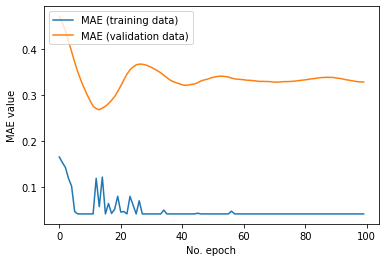

In [91]:
plt.plot(hist.history['mae'], label='MAE (training data)')
plt.plot(hist.history['val_mae'], label='MAE (validation data)')

plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [95]:
prediksi=model.predict([21, 22, 23])
prediksi

array([[0.18251646],
       [0.18189527],
       [0.1812896 ]], dtype=float32)

In [96]:
import matplotlib.pyplot as plt


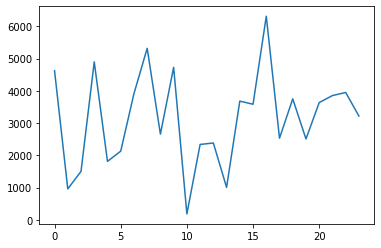

In [97]:
series = series * max
series = series + min
plt.plot(series)

In [98]:
prediksi = prediksi * max
prediksi = prediksi + min
prediksi

array([[1333.7739],
       [1329.8506],
       [1326.0251]], dtype=float32)

In [99]:
prediksi=prediksi.flatten()

In [100]:
hasil=np.concatenate((series[:-split_time],prediksi))

In [101]:
hasil

array([4624.        ,  959.        , 1500.        , 4900.        ,
       1812.        , 2128.        , 3913.        , 5320.        ,
       2657.        , 4730.        ,  181.        , 2337.        ,
       2382.        , 1005.        , 3682.        , 3585.        ,
       6316.        , 2531.        , 3752.        , 2508.        ,
       3637.        , 1333.77392578, 1329.85058594, 1326.02514648])

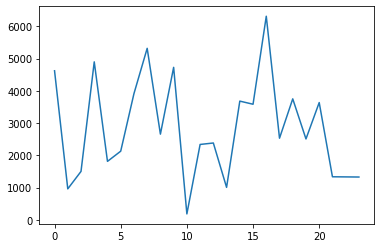

In [102]:
plt.plot(hasil)